In [19]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [20]:
dataset = pd.read_csv('/content/audio_features_scaled.csv')

In [21]:
df = pd.DataFrame(dataset)
df.groupby('year').size()

,0
year,
2017,50
2018,70
2019,37
2022,10
2023,14
2024,32


In [22]:
X = df.drop(columns=['year'])
y = df['year']
le = LabelEncoder()
y = le.fit_transform(y)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Parámetros para clasificación multiclase
num_classes = len(np.unique(y))
params = {
    'objective': 'multi:softmax',  # Para clasificación multiclase
    'eval_metric': 'mlogloss',
    'num_class': num_classes,
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

In [31]:
# Lista de evaluación para hacer seguimiento del entrenamiento
evals = [(dtrain, 'train'), (dval, 'eval')]

# Entrenamiento
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10
)

# Una vez entrenado, puedes predecir sobre nuevos datos usando:
dtest = xgb.DMatrix(X_val)
y_pred=model.predict(dtest)

accuracy= accuracy_score(y_val,y_pred)
print('Accuracy of the model xgboost is:', accuracy)

[0]	train-mlogloss:1.60197	eval-mlogloss:1.63771
[1]	train-mlogloss:1.45126	eval-mlogloss:1.50095
[2]	train-mlogloss:1.32698	eval-mlogloss:1.40319
[3]	train-mlogloss:1.21442	eval-mlogloss:1.30649
[4]	train-mlogloss:1.11692	eval-mlogloss:1.22476
[5]	train-mlogloss:1.03016	eval-mlogloss:1.16037
[6]	train-mlogloss:0.95117	eval-mlogloss:1.09929
[7]	train-mlogloss:0.87874	eval-mlogloss:1.04364
[8]	train-mlogloss:0.81627	eval-mlogloss:0.99577
[9]	train-mlogloss:0.76101	eval-mlogloss:0.95664
[10]	train-mlogloss:0.70926	eval-mlogloss:0.91205
[11]	train-mlogloss:0.66017	eval-mlogloss:0.86199
[12]	train-mlogloss:0.61708	eval-mlogloss:0.83059
[13]	train-mlogloss:0.58023	eval-mlogloss:0.79814
[14]	train-mlogloss:0.54565	eval-mlogloss:0.77889
[15]	train-mlogloss:0.50910	eval-mlogloss:0.75126
[16]	train-mlogloss:0.47885	eval-mlogloss:0.72060
[17]	train-mlogloss:0.45024	eval-mlogloss:0.70321
[18]	train-mlogloss:0.42409	eval-mlogloss:0.68709
[19]	train-mlogloss:0.39942	eval-mlogloss:0.66723
[20]	train

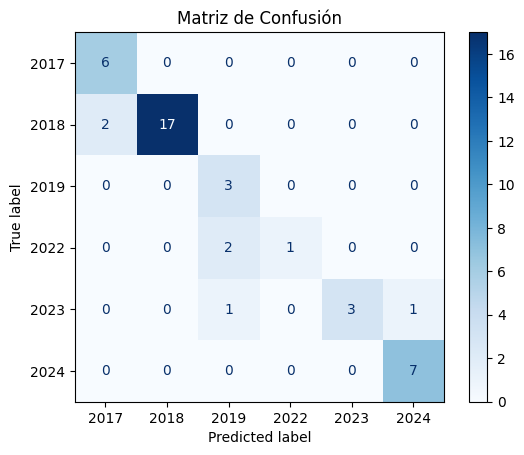

In [26]:
from sklearn.metrics import confusion_matrix

# Tras haber entrenado el modelo y obtenido las predicciones
y_pred_test = model.predict(dtest)  # Suponiendo que ya creaste dtest

# Generar la matriz de confusión
cm = confusion_matrix(y_val, y_pred_test)

# Graficar la matriz
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


In [27]:
# Cargar DataFrame llamado new_data con los datos nuevos
new_data=pd.read_csv('audios_predicciones.csv')

In [29]:

# Realizar las predicciones
dnew = xgb.DMatrix(new_data)
predicciones_nuevas = model.predict(dnew)

# Combinar las características y las predicciones en un DataFrame
resultados = new_data.copy()  # Copia los datos originales
resultados['Predicted Value'] = predicciones_nuevas  # Añadir columna de predicciones

# Mostrar las primeras filas de los resultados
print(resultados.head(10))

# Exportar los resultados a un archivo CSV para análisis posterior
resultados.to_csv('predicciones_con_features.csv', index=False)
print("Resultados exportados a 'predicciones_con_features.csv'")

   duration  mean_freq  max_magnitude  mean_magnitude    mfcc_1    mfcc_2  \
0  0.172098        0.0       0.997974        0.414381  0.784210  0.495728   
1  0.178467        0.0       0.499459        0.053960  0.686033  0.406364   
2  0.365845        0.0       0.997944        0.049158  0.725834  0.432923   
3  0.281806        0.0       0.997974        0.089981  0.692573  0.285843   
4  0.085682        1.0       0.706464        0.041868  0.646236  0.168733   
5  0.066140        1.0       0.997944        0.116978  0.727167  0.376520   
6  0.519327        0.0       0.417528        0.046565  0.625772  0.400752   
7  0.037268        0.0       0.407751        0.006633  0.604593  0.370281   
8  0.530736        0.0       0.499231        0.040369  0.648633  0.332650   
9  0.543676        0.0       0.499139        0.052986  0.656181  0.431597   

     mfcc_3    mfcc_4    mfcc_5    mfcc_6  ...    mel_32    mel_33    mel_34  \
0  0.585260  0.459847  0.811677  0.544788  ...  0.000742  0.000702  0.00

In [30]:
# Valores predichos (transformados)
predicted_values = [0.0, 1.0, 1.0, 3.0, 5.0, 5.0, 1.0, 2.0, 1.0, 1.0]

# Diccionario para mapear los índices a los años originales
label_mapping = {
    0: 2017,
    1: 2018,
    2: 2019,
    3: 2022,
    4: 2023,
    5: 2024
}

# Convertir valores predichos a etiquetas originales
original_labels = [label_mapping[int(value)] for value in predicted_values]

# Mostrar los resultados
print("Original Labels:", original_labels)


Original Labels: [2017, 2018, 2018, 2022, 2024, 2024, 2018, 2019, 2018, 2018]
